In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [2]:
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki
import dipy.reconst.cross_validation as xval
import dipy.core.gradients as dpg
from dipy.segment.mask import median_otsu

In [3]:
import nibabel as nib

In [4]:
import tools
import imp
imp.reload(tools)
from tools import resample_volume

In [5]:
dwi_img = nib.load('/home/ubuntu/data/991267/sess/dwi/dwi.nii.gz')
gtab = dpg.gradient_table('/home/ubuntu/data/991267/sess/dwi/dwi.bvals', 
                          '/home/ubuntu/data/991267/sess/dwi/dwi.bvecs',
                          b0_threshold=10)

In [6]:
data = dwi_img.get_data()

In [7]:
t1_img = nib.load('/home/ubuntu/data/991267/sess/anat/T1w_acpc_dc.nii.gz')
label_img = nib.load('/home/ubuntu/data/991267/sess/anat/aparc+aseg.nii.gz')

In [8]:
resamp_t1 = resample_volume(t1_img, dwi_img)
resamp_label = resample_volume(label_img, dwi_img)

In [9]:
resamp_label.shape, resamp_t1.shape, dwi_img.shape

((145, 174, 145), (145, 174, 145), (145, 174, 145, 288))

In [10]:
t1_data = resamp_t1.get_data()
label_data = resamp_label.get_data()

In [11]:
# Cerebral white matter in both hemispheres + corpus callosum
wm_mask = (label_data==41) | (label_data==2) | (label_data==86)

In [12]:
dki_model = dki.DiffusionKurtosisModel(gtab)
dti_model = dti.TensorModel(gtab)

In [13]:
def calc_cod(model, data, mask, folds=2):
    pred = xval.kfold_xval(model, data, folds, mask=mask)
    cod = xval.coeff_of_determination(pred, data)
    return cod

In [15]:
cod_dki = calc_cod(dki_model, data, wm_mask) 
cod_dti = calc_cod(dti_model, data, wm_mask)

/home/ubuntu/source/dipy/dipy/reconst/cross_validation.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return 100 * (1 - (ss_err/ss_tot))
/home/ubuntu/source/dipy/dipy/reconst/cross_validation.py:57: RuntimeWarning: invalid value encountered in true_divide
  return 100 * (1 - (ss_err/ss_tot))


(-15, 15)

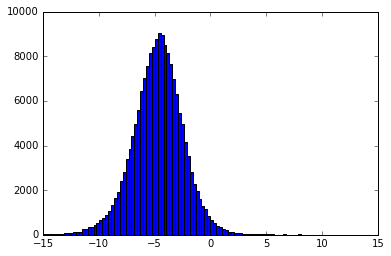

In [16]:
plt.hist(cod_dti[np.isfinite(cod_dki)] - cod_dki[np.isfinite(cod_dki)], bins=1000)
plt.xlim([-15, 15])

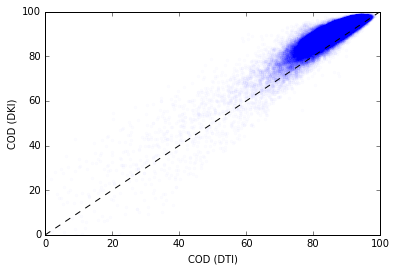

In [23]:
plt.plot(cod_dti[np.isfinite(cod_dki)], cod_dki[np.isfinite(cod_dki)], '.', alpha=0.01)
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.plot([0, 100], [0, 100], 'k--')
plt.xlabel("COD (DTI)")
plt.ylabel("COD (DKI)")

In [24]:
dki_fit = dki_model.fit(data, mask=wm_mask)
dti_fit = dti_model.fit(data, mask=wm_mask)

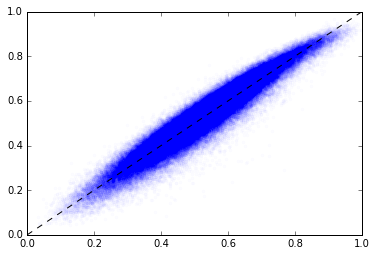

In [27]:
plt.plot(dki_fit.fa[wm_mask], dti_fit.fa[wm_mask], '.', alpha=0.01)
plt.plot([0, 1], [0, 1], 'k--')

In [28]:
np.corrcoef(dki_fit.fa[wm_mask], dti_fit.fa[wm_mask])

array([[ 1.        ,  0.95582013],
       [ 0.95582013,  1.        ]])

In [35]:
idx1000 = (gtab.bvals < 1100) | (gtab.bvals <= 5)
idx2000 = ((gtab.bvals > 1100) & (gtab.bvals < 2100 )) | (gtab.bvals <= 5)
idx3000 = (gtab.bvals > 2100) | (gtab.bvals <= 5)

In [39]:
data1000 = data[..., idx1000]
data2000 = data[..., idx2000]
data3000 = data[..., idx3000]

In [40]:
gtab1000 = dpg.gradient_table(gtab.bvals[idx1000], gtab.bvecs[idx1000], b0_threshold=5)
gtab2000 = dpg.gradient_table(gtab.bvals[idx1000], gtab.bvecs[idx1000], b0_threshold=5)
gtab3000 = dpg.gradient_table(gtab.bvals[idx1000], gtab.bvecs[idx1000], b0_threshold=5)

In [41]:
dti_model1000 = dti.TensorModel(gtab1000)
dti_model2000 = dti.TensorModel(gtab2000)
dti_model3000 = dti.TensorModel(gtab3000)

In [ ]:
dti_fit1000 = dti_model1000.fit(data1000, mask=wm_mask)
dti_fit2000 = dti_model2000.fit(data2000, mask=wm_mask)
dti_fit3000 = dti_model3000.fit(data3000, mask=wm_mask)

In [ ]:
np.corrcoef(dti_fit1000.fa[wm_mask], dti_fit2000.fa[wm_mask])